# ML Pipeline

This notebook simply introduces to some of the concepts to be considered when designing a ML pipeline. We will play with the Titanic dataset to illustrate the sequence of tasks to be accomplished to solve a typical ML problem.

We will leverage most of our routines in the SKLearn API to build the pipelines and some of the tasks (including the model), but typically you will also need `pandas` and `numpy`. Optionally, you will find useful to plot results using `matplotlib` or `seaborn`.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Ensure reproducibility
np.random.seed(1234)

## Fetch Data

In [69]:
dataset_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic = pd.read_csv(dataset_url)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Quantitative/Qualitative information about data

In [6]:
from pandas_profiling import ProfileReport

# Click https://github.com/ydataai/pandas-profiling for more information.
profile = ProfileReport(titanic, title="Pandas Profiling Report")
profile.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

A different way of looking to the histograms, simpler, though not so informative.

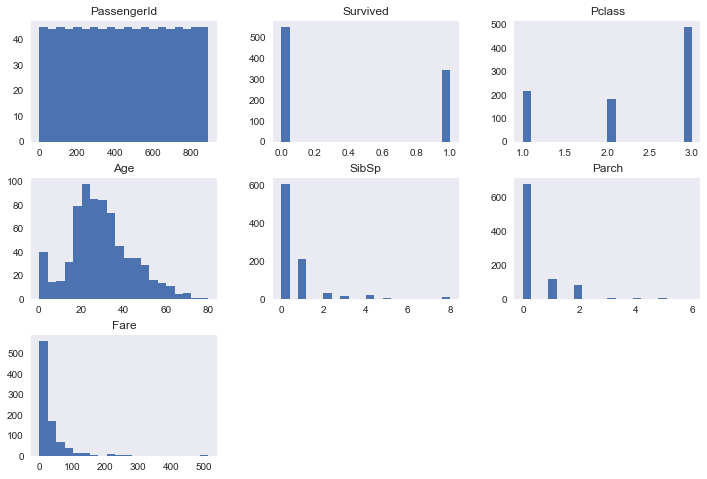

In [37]:
titanic.hist(bins=20, figsize=(12,8), grid=False);

## Basic Data Cleaning

We've missing values in Age, Embarked and Cabin features.

In [38]:
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


One possible strategy is to impute, but we don't really know if that will work, so I decide to drop those missing values, since they're only two.

I'm also getting rid of `Cabin` and `Ticket` since they are noise at this moment.

In [70]:
titanic.drop(labels=['Cabin', 'Ticket'], axis=1, inplace=True)
titanic = titanic[titanic.Embarked.notna()].copy(deep=True)
pd.isnull(titanic).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

### Age NULLs

We've a problem with that column... so what can we do?

In [71]:
nr_null_aged = titanic[titanic.Age.isnull()].shape[0]
print(f"There are {nr_null_aged} NULLs in Age column")

There are 177 NULLs in Age column


## Imputation 

Let's work on `Age`. We should build a powerful predictor that will help us to assign the missing values for Age column, but since we're starting with ML, let's simply use the median of the age (per gender) to fill them.

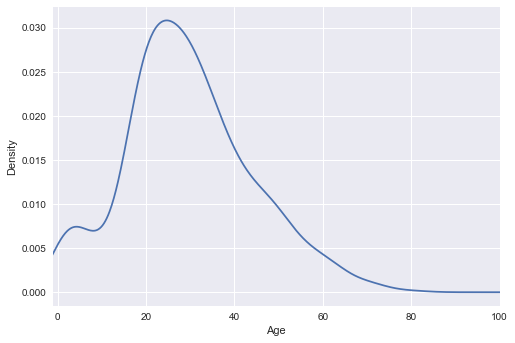

In [72]:
titanic.Age.plot.density()
plt.xlim(-1, 100); plt.xlabel("Age")
plt.show()

In [73]:
med_age_males = titanic[(titanic.Age.notnull()) & (titanic.Sex == "male")]['Age'].median()
med_age_females = titanic[(titanic.Age.notnull()) & (titanic.Sex == "female")]['Age'].median()

titanic.loc[(titanic.Age.isnull()) & (titanic.Sex == "male"), 'Age'] = med_age_males
titanic.loc[(titanic.Age.isnull()) & (titanic.Sex == "female"), 'Age'] = med_age_females

Let's see how `Age` looks like now.

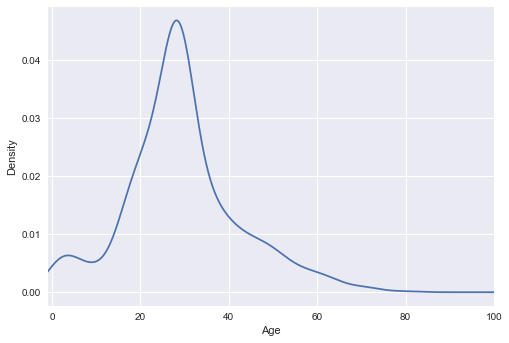

In [74]:
titanic.Age.plot.density()
plt.xlim(-1, 100); plt.xlabel("Age")
plt.show()

# Fix non-normal distributions

Remeber that we're using a model that requires every feature to have a normal distribution. However, after lookng at them they don't look terrible skewed, so let's keep them as they are. Remeber you can use `log()` or [BoxCox or Yeo-Johnson corrections](https://stackoverflow.com/a/53625434/892904) to fix them.


## EDA – Relationships between variables.

Start by knowing what is the relation between Fare and Age for those who survived and those who didn't.

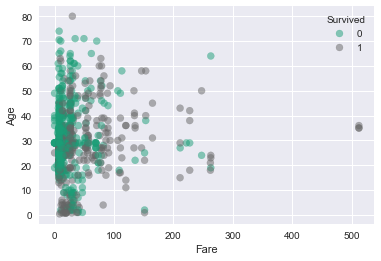

In [75]:
plt.figure(figsize=(6, 4))
fare_names = [str(titanic.Survived.unique()[i]) for i in titanic.Survived.unique()]
scatter = plt.scatter(titanic['Fare'], titanic['Age'], 
    c=titanic['Survived'],
    alpha=0.5, cmap='Dark2')
plt.legend(handles=scatter.legend_elements()[0], labels=fare_names, title="Survived")
plt.xlabel("Fare"); plt.ylabel("Age")
plt.show();

Make a different plot for each class.

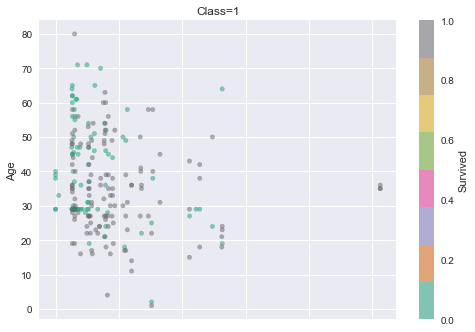

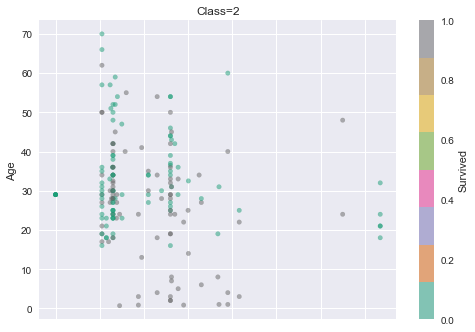

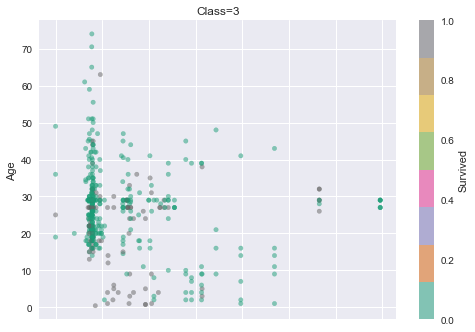

In [76]:
titanic[titanic['Pclass']==1].plot.scatter(x="Fare", y="Age", c="Survived", colormap="Dark2", alpha=0.5, title="Class=1")
titanic[titanic['Pclass']==2].plot.scatter(x="Fare", y="Age", c="Survived", colormap="Dark2", alpha=0.5, title="Class=2")
titanic[titanic['Pclass']==3].plot.scatter(x="Fare", y="Age", c="Survived", colormap="Dark2", alpha=0.5, title="Class=3");

Work now with Fare and Age, for the different genders.

<AxesSubplot:xlabel='Fare', ylabel='Age'>

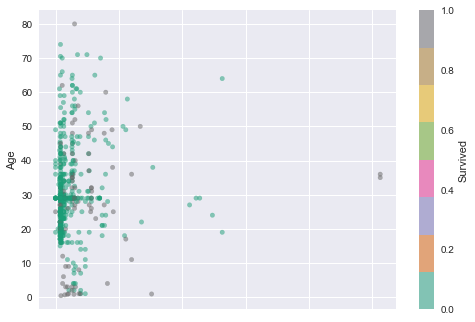

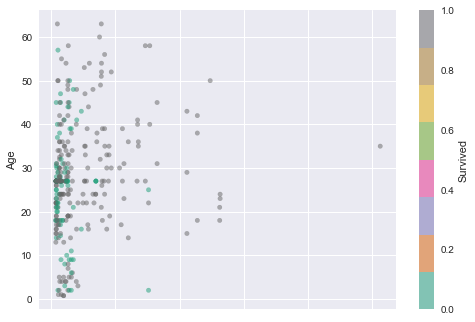

In [77]:
titanic[titanic['Sex']=='male'].plot.scatter("Fare", "Age", c="Survived", colormap="Dark2", alpha=0.5)
titanic[titanic['Sex']=='female'].plot.scatter("Fare", "Age", c="Survived", colormap="Dark2", alpha=0.5)

<AxesSubplot:title={'center':'Age'}, xlabel='[Survived, Pclass]'>

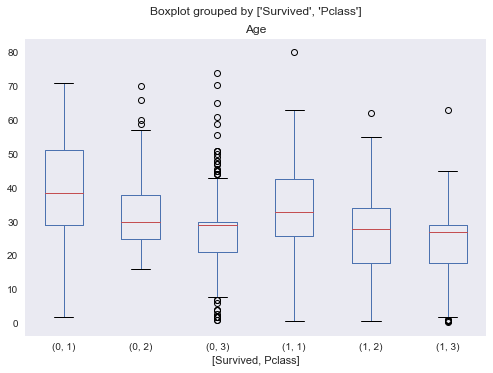

In [78]:
titanic.boxplot("Age", by=["Survived", "Pclass"], grid=False)

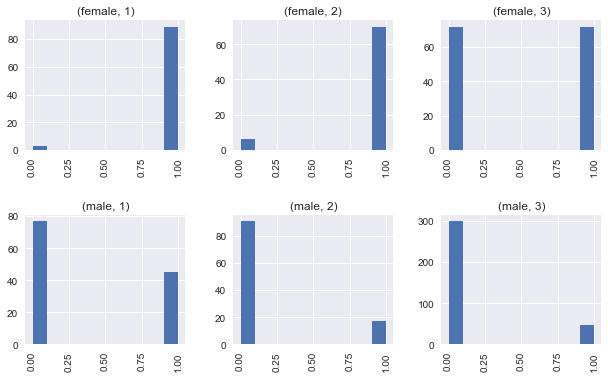

In [79]:
titanic.hist("Survived", by=["Sex", "Pclass"], figsize=(10,6), layout=(2, 3)); # sharey=True

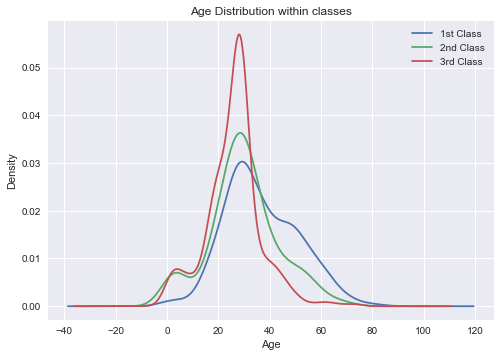

In [80]:
titanic.Age[titanic.Pclass == 1].plot(kind='kde')    
titanic.Age[titanic.Pclass == 2].plot(kind='kde')
titanic.Age[titanic.Pclass == 3].plot(kind='kde')

plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') ;

## OneHot encoding

**Convert** categorical into numericals by using OneHotEncoder

In [81]:
titanic['male'] = pd.get_dummies(titanic.Sex, drop_first=True)
titanic.drop('Sex', axis=1, inplace=True)

In [82]:
newcols = pd.get_dummies(titanic.Embarked, drop_first=True, prefix="Port")
titanic = pd.concat([titanic, newcols], axis=1)
titanic.drop(['Embarked'], axis=1, inplace=True)
titanic.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Port_Q,Port_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,1,0,1


## Baseline

What is the performance of the basic model with no added features?

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


features = ["Pclass", "male", "Age", "Fare", "Port_Q", "Port_S" ]
target = "Survived"

X_train = titanic[features]
y_train = titanic[target]
X_training, X_valid, y_training, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=4321)


Linear Regression

In [84]:
linreg = LinearRegression()
linreg.fit(X_training, y_training)
predictions = np.array(linreg.predict(X_valid))
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = accuracy_score(y_valid, predictions)
accuracy

0.7921348314606742

Logistic Regression

In [85]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_training, y_training)
pred_logreg = logreg_clf.predict(X_valid)
acc_logreg = accuracy_score(y_valid, pred_logreg)

print(acc_logreg)

0.7865168539325843


## Feature Engineering

**Family size**

Given that the variable `Parch`is the nr of Parents/Children aboard, and `SibSp` is the number of siblings/spouses aboard, we can build a feature that tell us if you've family aboard, and what is its size.

In [86]:
titanic["FamilyMembers"] = titanic["SibSp"] + titanic["Parch"]+1
print(titanic["FamilyMembers"].value_counts())

1     535
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilyMembers, dtype: int64


In [87]:
titanic.loc[titanic["FamilyMembers"] == 1, "FamSize"] = 'single'
titanic.loc[(titanic["FamilyMembers"] > 1) & (titanic["FamilyMembers"] < 5), "FamSize"] = 'normal'
titanic.loc[titanic["FamilyMembers"] >= 5, "FamSize"] = 'large'
titanic.FamSize.value_counts()

single    535
normal    292
large      62
Name: FamSize, dtype: int64

We can see that the new feature containes information on the survival rate.

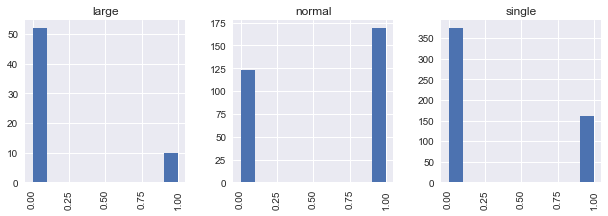

In [88]:
titanic.hist("Survived", by="FamSize", figsize=(10,3), layout=(1,3));

## Model Construction and Evaluation

First, we need to onehot encode the new feature.

In [89]:
newcols = pd.get_dummies(titanic.FamSize, drop_first=True, prefix="fam")
titanic = pd.concat([titanic, newcols], axis=1)
titanic.drop(['FamSize', 'FamilyMembers', 'SibSp', 'Parch'], axis=1, inplace=True)

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


features = ["Pclass", "male", "Age", "Fare", "Port_Q", "Port_S",
            "fam_normal", "fam_single", ]
target = "Survived"

X_train = titanic[features]
y_train = titanic[target]
X_training, X_valid, y_training, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=4321)


Linear Regression

In [91]:
linreg = LinearRegression()
linreg.fit(X_training, y_training)
predictions = np.array(linreg.predict(X_valid))
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = accuracy_score(y_valid, predictions)
accuracy

0.7921348314606742

Logistic Regression

In [92]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_training, y_training)
pred_logreg = logreg_clf.predict(X_valid)
acc_logreg = accuracy_score(y_valid, pred_logreg)

print(acc_logreg)

0.797752808988764
